# Uniswap V2 Simulation (Part 1) 
* To download notebook to this tutorial, see [here](https://github.com/defipy-devs/uniswappy/blob/main/notebooks/medium_articles/simple_simulation.ipynb) 

In [20]:
from defipy import *
import numpy as np
import datetime
import matplotlib.pyplot as plt

### Simulate GBM process

In [21]:
# Instantiation Parameters
n_steps = 500     # Number of steps 
start_price = 10 # Initial price SYS/USD
mu = 0.1; sigma = 0.5
n_paths = 1      # Number of simulationed paths
seconds_year = 31536000

# Brownian Model 
bm = BrownianModel(start_price)
p_arr = bm.gen_gbms(mu, sigma, n_steps-1, n_paths).flatten()

dt = datetime.timedelta(seconds=seconds_year/n_steps)
dates = [datetime.datetime.strptime("2024-09-01", '%Y-%m-%d') + k*dt for k in range(n_steps)]

### Setup UniV2 Pool

In [22]:
user_nm = 'user0'
tkn1_amount = 1000
tkn2_amount = p_arr[0]*tkn1_amount

In [23]:
tkn1_nm = 'TKN1'
tkn2_nm = 'TKN2'

tkn1 = ERC20('TKN1', "0x111")
tkn2 = ERC20('TKN2', "0x09")
exchg_data = UniswapExchangeData(tkn0 = tkn1, tkn1 = tkn2, symbol="LP", address="0x011")

factory = UniswapFactory("pool factory", "0x2")
lp = factory.deploy(exchg_data)
Join().apply(lp, user_nm, tkn1_amount, tkn2_amount)

lp.summary()

Exchange TKN1-TKN2 (LP)
Reserves: TKN1 = 1000.0, TKN2 = 10000.0
Liquidity: 3162.2776601683795 



### Simulation: Random Swapping

In [24]:
arb = CorrectReserves(lp, x0 = p_arr[0])
TKN_amt = TokenDeltaModel(100)
pTKN1_TKN2_arr = []; 

for k in range(n_steps):

    # *****************************
    # ***** Random Swapping ******
    # *****************************
    Swap().apply(lp, tkn1, user_nm, TKN_amt.delta())
    Swap().apply(lp, tkn2, user_nm, p_arr[k]*TKN_amt.delta())
    
    # *****************************
    # ***** Rebalance ******
    # *****************************
    arb.apply(p_arr[k])

    # *****************************
    # ******* Data Capture ********
    # *****************************
    pTKN1_TKN2_arr.append(LPQuote().get_price(lp, tkn1))

lp.summary()

Exchange TKN1-TKN2 (LP)
Reserves: TKN1 = 931.2998693040525, TKN2 = 16330.8976587654
Liquidity: 3740.037906127559 



### Plot Results

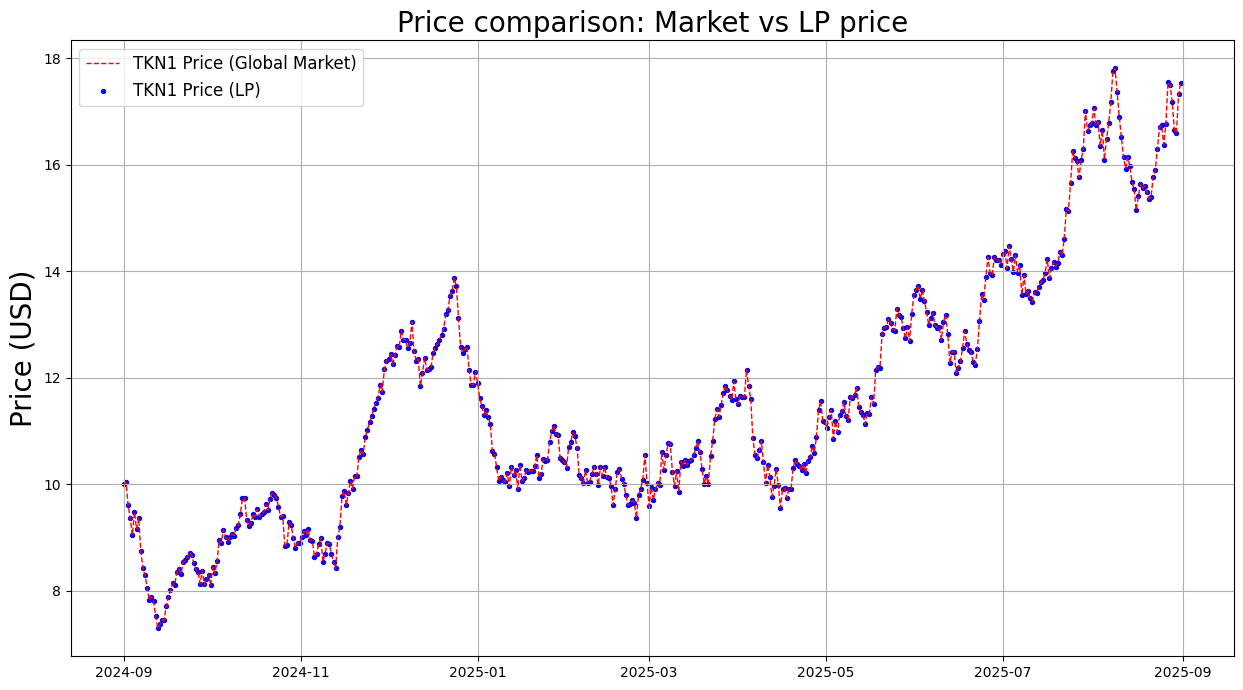

In [25]:
fig, (TKN_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(15, 8))

TKN_ax.plot(dates, p_arr, color = 'r',linestyle = 'dashed', linewidth=1, label=f'{tkn1_nm} Price (Global Market)')
TKN_ax.scatter(dates, pTKN1_TKN2_arr, s=10, marker='o', color = 'b',linestyle = '-', linewidth=0.7, label=f'{tkn1_nm} Price (LP)')

TKN_ax.set_title('Price comparison: Market vs LP price', fontsize=20)
TKN_ax.set_ylabel('Price (USD)', size=20)
TKN_ax.legend(fontsize=12)
TKN_ax.grid()